In [26]:
from models import Denoiser_CondUNet
import torch
import os
import numpy as np
import deepinv as dinv
import nibabel as nib
import glob
import monai.transforms as mt

import matplotlib.pyplot as plt


logdir_path = './checkpoints/'
if os.path.exists(logdir_path)==False:
    os.mkdir(logdir_path)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

Denoiser = Denoiser_CondUNet(spatial_dims=3, in_channels=1, out_channels=1, features=(16, 32, 64, 128, 128, 16), norm='batch',upsample='nontrainable')
model_path = logdir_path+'Pretrained_Denoiser_l1loss_adni_epoch15.pth'
Denoiser = Denoiser.to(device)
if device == 'cpu':
    states = torch.load(model_path, map_location=lambda storage, loc: storage)
    Denoiser.load_state_dict(states['weights'])
else:
    states = torch.load(model_path)
    Denoiser.load_state_dict(states['weights'])
Denoiser.eval()
print("loaded Denoiser:"+model_path)

def denoiser3d(denoiserNet, v_var, sigma):
    mt_scale = mt.ScaleIntensity(minv=0., maxv=1.0)
    v_var = mt_scale(v_var)
    predict,_,_ = denoiserNet(v_var, sigma)
    used_sigmas2 = sigma ** 2
    predict_noise = (predict*used_sigmas2)
    denoised = v_var - (predict_noise)
    return (denoised.clip(0,1)) 




cpu
BasicUNet features: (16, 32, 64, 128, 128, 16).
loaded Denoiser:./checkpoints/Pretrained_Denoiser_l1loss_adni_epoch15.pth


In [19]:
image_path = "inputs/t1n.nii.gz"
mask_path = "inputs/mask.nii.gz"


image = np.moveaxis(nib.load(image_path).get_fdata(), 2, 0)
mask = np.moveaxis(nib.load(mask_path).get_fdata(), 2, 0)

In [20]:
img = torch.tensor(image)
img_min = torch.min(img)
img_max = torch.max(img)
normalized_img = ((img - img_min) / (img_max - img_min)) 
sigma = 0.2

noisy_img = normalized_img + sigma * torch.normal(0, 1, size=normalized_img.shape)



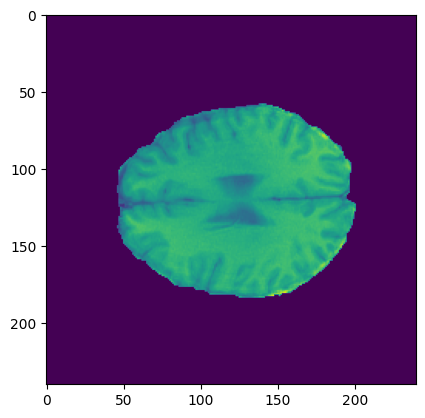

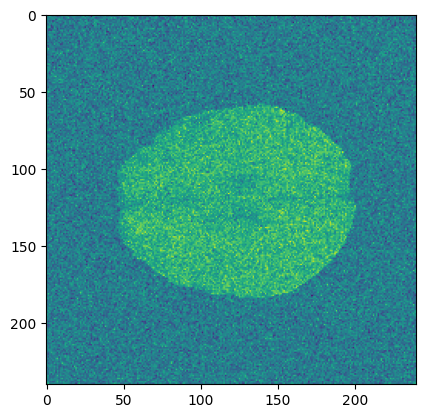

RuntimeError: Expected 4D (unbatched) or 5D (batched) input to conv3d, but got input of size: [155, 240, 240]

In [27]:
plt.imshow(normalized_img[100,:,:])
plt.show()

plt.imshow(noisy_img[100,:,:])
plt.show()



clean_img,_,_ = denoiser3d(Denoiser, noisy_img, sigma)
plt.imshow(clean_img[100,:,:])
plt.show()